### LSTM Neural Network Model
#### Robert Manriquez

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam

sns.set_style('darkgrid')

/Users/robertmanriquez/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
def TimeStampMaker(input_df):
    input_df['Timestamp'] = input_df['Year'].astype(str) + "-" + input_df['Month'].astype(str) + "-" + input_df['Day'].astype(str) +" "\
                                                        + input_df['Hour'].astype(str)+ ":" + input_df['Minute'].astype(str)
    
    input_df['Timestamp'] = pd.to_datetime([input_df['Timestamp']])
    input_df.set_index('Timestamp', inplace = True)    
    
def TimeSeriesFeatures(input_df):
    
    input_df = input_df.loc[input_df['Minute'] == 0,:].copy()
    
    input_df['Timestamp'] = input_df['Year'].astype(str) + "-" + input_df['Month'].astype(str) + "-" + input_df['Day'].astype(str) +" "\
                                        + input_df['Hour'].astype(str)+ ":" + input_df['Minute'].astype(str)
    
    input_df['Timestamp'] = pd.to_datetime(input_df['Timestamp'])
    input_df.set_index('Timestamp', inplace = True)
    input_df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis =1,inplace = True)
    
    return input_df

In [4]:
## Only looking at 1-hour intervals.

In [5]:
df_2016 = pd.read_csv('./data_psm_raw/Santa_Monica/83160_34.01_-118.46_2016.csv', header = 2)

df_2016 = TimeSeriesFeatures(df_2016).copy()

In [6]:
df_2016.head()

,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Fill Flag,Surface Albedo,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
Timestamp,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0,0,0,0,0,0,1.0,-4,169.00,0,0.12592,1.2,0.490,227.8,51.56,5,1010.0
2016-01-01 01:00:00,0,0,0,0,0,0,1.0,-4,162.39,0,0.12592,1.2,0.502,239.7,51.08,5,1010.0
2016-01-01 02:00:00,0,0,0,0,0,0,1.0,-4,151.00,0,0.12592,1.3,0.518,237.4,50.88,5,1010.0
2016-01-01 03:00:00,0,0,0,0,0,0,1.0,-4,138.71,0,0.12592,1.4,0.536,231.9,50.97,5,1010.0
2016-01-01 04:00:00,0,0,0,0,0,0,1.0,-4,126.29,0,0.12592,1.4,0.561,226.3,51.16,5,1010.0


In [7]:
def DataPrep(input_df, var, n_lags):
    
    output_df = input_df[[str(var)]].copy()
    
    for i in range(1,n_lags+1):
        output_df[str(var) + '(t-' + str(i) + ')'] = input_df[[str(var)]].shift(i)
#         print(i)
    
    return output_df.dropna()

In [8]:
x1 = DataPrep(df_2016, 'DNI', n_lags = 1).drop('DNI', axis = 1).copy()
y = DataPrep(df_2016, 'DNI', n_lags = 1)['DNI']

In [9]:
x2 = DataPrep(df_2016, 'DHI', n_lags = 1).drop('DHI', axis = 1).copy()
x3 = DataPrep(df_2016, 'Solar Zenith Angle', n_lags = 1).drop('Solar Zenith Angle', axis = 1).copy()

In [10]:
X_cat = pd.concat([x1,x2,x3], axis = 1).copy()
X_cat.shape

(8759, 3)

In [28]:
pd.concat([y,x1,x2,x3], axis = 1).head(15)

,DNI,DNI(t-1),DHI(t-1),Solar Zenith Angle(t-1)
Timestamp,,,,
2016-01-01 01:00:00,0,0.0,0.0,169.00
2016-01-01 02:00:00,0,0.0,0.0,162.39
2016-01-01 03:00:00,0,0.0,0.0,151.00
2016-01-01 04:00:00,0,0.0,0.0,138.71
2016-01-01 05:00:00,0,0.0,0.0,126.29
2016-01-01 06:00:00,0,0.0,0.0,114.02
2016-01-01 07:00:00,0,0.0,0.0,102.08
2016-01-01 08:00:00,604,0.0,0.0,90.69
2016-01-01 09:00:00,792,604.0,42.0,80.16


In [11]:
8759/2

4379.5

In [12]:
split = 4380

X_train = X_cat[:split].as_matrix().reshape(split,1,3)
y_train = y[:split].values.reshape(-1,1)

X_test = X_cat[split:].as_matrix().reshape(split-1,1,3)
y_test = y[split:].values.reshape(-1,1)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_train.shape

((4380, 1, 3), (4380, 1), (4379, 1, 3), (4380, 1))

In [14]:
model = Sequential()

model.add(LSTM(200, input_shape = (1,3)))
model.add(Dense(1))

model.compile(loss= "mean_squared_error", optimizer = 'adam')
model.fit(X_train, y_train, epochs = 1000, batch_size = 219, verbose = 2)

model.save('./keras_models/LSTM_1layer_3var_lag1.h5')

Epoch 1/1000
 - 1s - loss: 205624.4633
Epoch 2/1000
 - 0s - loss: 204306.2000
Epoch 3/1000
 - 0s - loss: 202944.3695
Epoch 4/1000
 - 0s - loss: 200951.5984
Epoch 5/1000
 - 0s - loss: 198919.8438
Epoch 6/1000
 - 0s - loss: 197226.4070
Epoch 7/1000
 - 0s - loss: 195768.8273
Epoch 8/1000
 - 0s - loss: 194533.5133
Epoch 9/1000
 - 0s - loss: 193246.7531
Epoch 10/1000
 - 0s - loss: 192066.5113
Epoch 11/1000
 - 0s - loss: 190954.6562
Epoch 12/1000
 - 0s - loss: 189855.7531
Epoch 13/1000
 - 0s - loss: 188770.5680
Epoch 14/1000
 - 0s - loss: 187662.8023
Epoch 15/1000
 - 0s - loss: 186629.4336
Epoch 16/1000
 - 0s - loss: 185625.5523
Epoch 17/1000
 - 0s - loss: 184639.5711
Epoch 18/1000
 - 0s - loss: 183677.9359
Epoch 19/1000
 - 0s - loss: 182726.3477
Epoch 20/1000
 - 0s - loss: 181792.0734
Epoch 21/1000
 - 0s - loss: 180874.4781
Epoch 22/1000
 - 0s - loss: 179966.3500
Epoch 23/1000
 - 0s - loss: 179057.8602
Epoch 24/1000
 - 0s - loss: 178170.3313
Epoch 25/1000
 - 0s - loss: 177292.0922
Epoch 26/

 - 0s - loss: 73939.1629
Epoch 206/1000
 - 0s - loss: 73621.0820
Epoch 207/1000
 - 0s - loss: 73310.4760
Epoch 208/1000
 - 0s - loss: 72891.3844
Epoch 209/1000
 - 0s - loss: 72509.3197
Epoch 210/1000
 - 0s - loss: 72156.6695
Epoch 211/1000
 - 0s - loss: 71806.2703
Epoch 212/1000
 - 0s - loss: 71480.9867
Epoch 213/1000
 - 0s - loss: 71171.5701
Epoch 214/1000
 - 0s - loss: 70888.2363
Epoch 215/1000
 - 0s - loss: 70553.6949
Epoch 216/1000
 - 0s - loss: 70229.6977
Epoch 217/1000
 - 0s - loss: 69899.6549
Epoch 218/1000
 - 0s - loss: 69580.5518
Epoch 219/1000
 - 0s - loss: 69274.7879
Epoch 220/1000
 - 0s - loss: 68996.0074
Epoch 221/1000
 - 0s - loss: 68747.6174
Epoch 222/1000
 - 0s - loss: 68449.4535
Epoch 223/1000
 - 0s - loss: 68157.6779
Epoch 224/1000
 - 0s - loss: 67875.2613
Epoch 225/1000
 - 0s - loss: 67621.3818
Epoch 226/1000
 - 0s - loss: 67234.3854
Epoch 227/1000
 - 0s - loss: 66935.0289
Epoch 228/1000
 - 0s - loss: 66651.1711
Epoch 229/1000
 - 0s - loss: 66359.9211
Epoch 230/1000


 - 0s - loss: 35291.1521
Epoch 411/1000
 - 0s - loss: 35251.7633
Epoch 412/1000
 - 0s - loss: 35251.4263
Epoch 413/1000
 - 0s - loss: 35191.6808
Epoch 414/1000
 - 0s - loss: 35076.2622
Epoch 415/1000
 - 0s - loss: 34992.0329
Epoch 416/1000
 - 0s - loss: 34972.3262
Epoch 417/1000
 - 0s - loss: 34806.0830
Epoch 418/1000
 - 0s - loss: 34749.8375
Epoch 419/1000
 - 0s - loss: 34584.1437
Epoch 420/1000
 - 0s - loss: 34336.1868
Epoch 421/1000
 - 0s - loss: 34326.8687
Epoch 422/1000
 - 0s - loss: 34333.6141
Epoch 423/1000
 - 0s - loss: 34137.9786
Epoch 424/1000
 - 0s - loss: 34125.5461
Epoch 425/1000
 - 0s - loss: 33997.4853
Epoch 426/1000
 - 0s - loss: 33961.0624
Epoch 427/1000
 - 0s - loss: 33867.1737
Epoch 428/1000
 - 0s - loss: 33823.2434
Epoch 429/1000
 - 0s - loss: 33679.2609
Epoch 430/1000
 - 0s - loss: 33496.7789
Epoch 431/1000
 - 0s - loss: 33384.5531
Epoch 432/1000
 - 0s - loss: 33316.5388
Epoch 433/1000
 - 0s - loss: 33304.4761
Epoch 434/1000
 - 0s - loss: 33212.8550
Epoch 435/1000


 - 0s - loss: 26241.0114
Epoch 616/1000
 - 0s - loss: 26225.1718
Epoch 617/1000
 - 0s - loss: 26167.3521
Epoch 618/1000
 - 0s - loss: 26117.5486
Epoch 619/1000
 - 0s - loss: 26068.8356
Epoch 620/1000
 - 0s - loss: 26177.6068
Epoch 621/1000
 - 0s - loss: 26025.1460
Epoch 622/1000
 - 0s - loss: 26073.0390
Epoch 623/1000
 - 0s - loss: 26013.1292
Epoch 624/1000
 - 0s - loss: 26041.4519
Epoch 625/1000
 - 0s - loss: 25985.7222
Epoch 626/1000
 - 0s - loss: 26012.1435
Epoch 627/1000
 - 0s - loss: 25990.9600
Epoch 628/1000
 - 0s - loss: 25928.7685
Epoch 629/1000
 - 0s - loss: 25974.9721
Epoch 630/1000
 - 0s - loss: 26059.0452
Epoch 631/1000
 - 0s - loss: 25918.4699
Epoch 632/1000
 - 0s - loss: 25870.6437
Epoch 633/1000
 - 0s - loss: 25907.0225
Epoch 634/1000
 - 0s - loss: 25890.3723
Epoch 635/1000
 - 0s - loss: 25924.8763
Epoch 636/1000
 - 0s - loss: 25869.7750
Epoch 637/1000
 - 0s - loss: 25819.6063
Epoch 638/1000
 - 0s - loss: 25866.5224
Epoch 639/1000
 - 0s - loss: 25775.9212
Epoch 640/1000


Epoch 821/1000
 - 0s - loss: 23925.0658
Epoch 822/1000
 - 0s - loss: 23916.0781
Epoch 823/1000
 - 0s - loss: 23912.1919
Epoch 824/1000
 - 0s - loss: 23935.8384
Epoch 825/1000
 - 0s - loss: 23847.2019
Epoch 826/1000
 - 0s - loss: 23857.8271
Epoch 827/1000
 - 0s - loss: 24083.0178
Epoch 828/1000
 - 0s - loss: 23967.7884
Epoch 829/1000
 - 0s - loss: 23941.8716
Epoch 830/1000
 - 0s - loss: 23908.5410
Epoch 831/1000
 - 0s - loss: 23887.1729
Epoch 832/1000
 - 0s - loss: 23882.7103
Epoch 833/1000
 - 0s - loss: 23831.3935
Epoch 834/1000
 - 0s - loss: 23955.5272
Epoch 835/1000
 - 0s - loss: 24016.6433
Epoch 836/1000
 - 0s - loss: 23977.2617
Epoch 837/1000
 - 0s - loss: 23911.9700
Epoch 838/1000
 - 0s - loss: 23857.5630
Epoch 839/1000
 - 0s - loss: 23800.1221
Epoch 840/1000
 - 0s - loss: 23781.2631
Epoch 841/1000
 - 0s - loss: 23832.7124
Epoch 842/1000
 - 0s - loss: 24009.3621
Epoch 843/1000
 - 0s - loss: 23871.9280
Epoch 844/1000
 - 0s - loss: 23882.0658
Epoch 845/1000
 - 0s - loss: 23916.9682


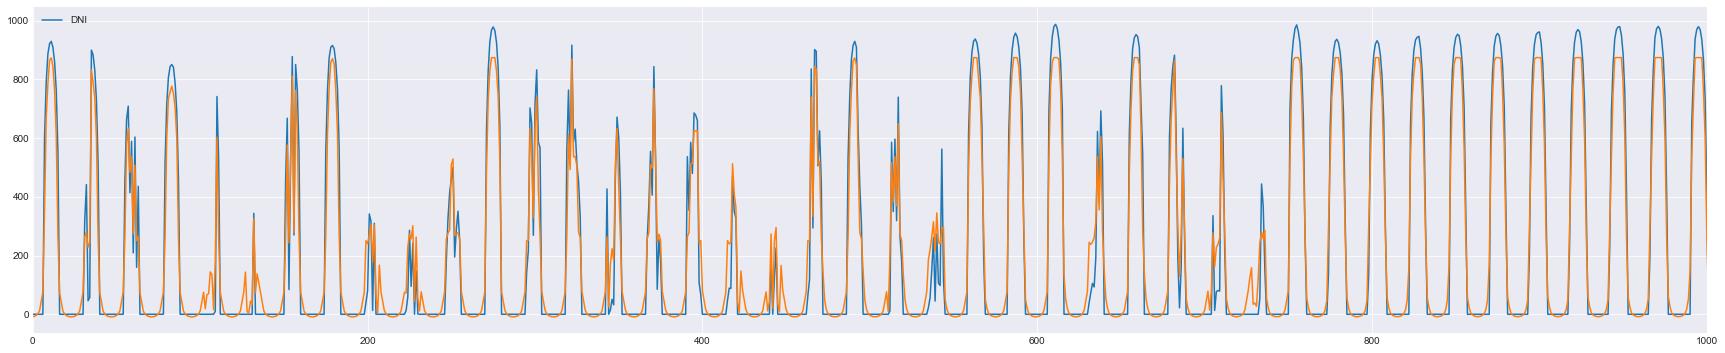

In [15]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

plt.figure(figsize = (30,6))

plot_x1 = np.arange(0,len(y))

plt.plot(plot_x1, y)

plt.plot(plot_x1[:len(y_train)]-1, trainPredict.ravel())

plt.xlim(0,1000)
plt.legend()
plt.show()

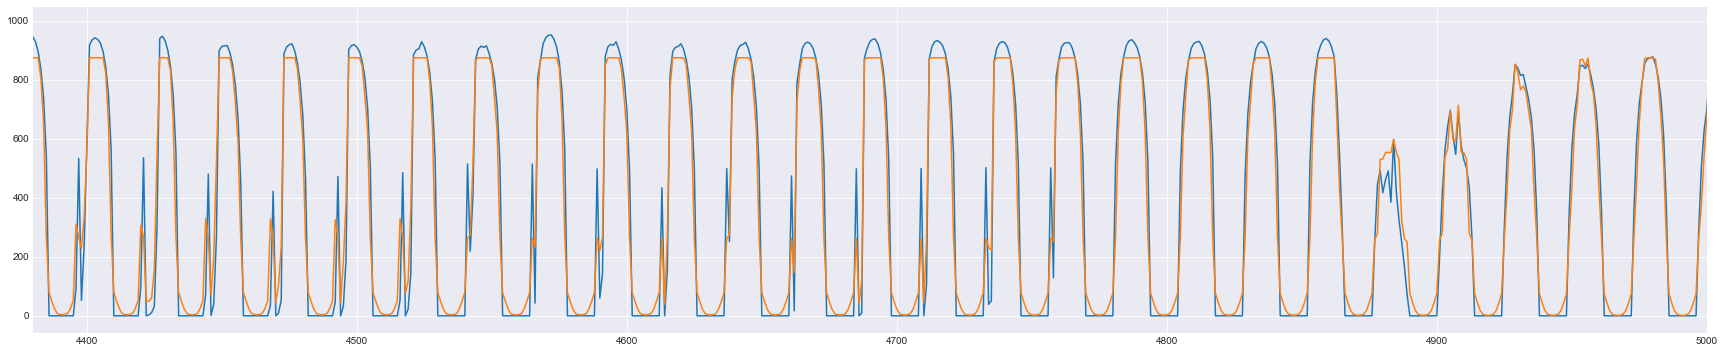

In [17]:
testPredict = model.predict(X_test)

plt.figure(figsize = (30,6))

plot_x2 = np.arange(4380,4380 + len(y_test))

plt.plot(plot_x2, y_test)

plt.plot(plot_x2-1, testPredict.ravel())

plt.xlim(4380, 5000)
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import r2_score

r2_score(y_train, trainPredict), r2_score(y_test, testPredict)

(0.8239870220573737, 0.8358516596208541)

In [19]:
batch_size = 219
lag = 1

model2 = Sequential()

model2.add(LSTM(200, batch_input_shape=(batch_size, lag, 3), return_sequences = True))
model2.add(Dropout(0.25))
model2.add(LSTM(200, batch_input_shape=(batch_size, lag, 3), return_sequences = True))
model2.add(Dropout(0.25))
model2.add(LSTM(100, batch_input_shape=(batch_size, lag, 3)))
model2.add(Dense(1))

model2.compile(loss= "mean_squared_error", optimizer = 'adam')

model2.fit(X_train, y_train, epochs = 1000, batch_size = 219, verbose = 2, shuffle=False)
model2.save('./keras_models/LSTM_3layer_3var_lag1.h5')

Epoch 1/1000
 - 3s - loss: 205604.7969
Epoch 2/1000
 - 1s - loss: 201358.7523
Epoch 3/1000
 - 1s - loss: 199105.9133
Epoch 4/1000
 - 1s - loss: 198095.1965
Epoch 5/1000
 - 1s - loss: 197162.4039
Epoch 6/1000
 - 1s - loss: 196279.8465
Epoch 7/1000
 - 1s - loss: 195431.5699
Epoch 8/1000
 - 1s - loss: 194607.8336
Epoch 9/1000
 - 1s - loss: 193803.5422
Epoch 10/1000
 - 1s - loss: 193014.9734
Epoch 11/1000
 - 1s - loss: 192240.7227
Epoch 12/1000
 - 1s - loss: 191479.2539
Epoch 13/1000
 - 1s - loss: 190728.9191
Epoch 14/1000
 - 1s - loss: 189988.9211
Epoch 15/1000
 - 1s - loss: 189258.7758
Epoch 16/1000
 - 1s - loss: 188537.8539
Epoch 17/1000
 - 1s - loss: 187825.6898
Epoch 18/1000
 - 1s - loss: 187121.7398
Epoch 19/1000
 - 1s - loss: 186425.9418
Epoch 20/1000
 - 1s - loss: 185737.9910
Epoch 21/1000
 - 1s - loss: 185057.6824
Epoch 22/1000
 - 1s - loss: 184384.7008
Epoch 23/1000
 - 1s - loss: 183719.0262
Epoch 24/1000
 - 1s - loss: 183060.3246
Epoch 25/1000
 - 1s - loss: 182408.5953
Epoch 26/

 - 1s - loss: 91483.2602
Epoch 205/1000
 - 1s - loss: 91021.4051
Epoch 206/1000
 - 1s - loss: 90445.2080
Epoch 207/1000
 - 1s - loss: 90298.1062
Epoch 208/1000
 - 1s - loss: 89695.1029
Epoch 209/1000
 - 1s - loss: 89512.1719
Epoch 210/1000
 - 1s - loss: 88955.8076
Epoch 211/1000
 - 1s - loss: 89169.9236
Epoch 212/1000
 - 1s - loss: 88396.6088
Epoch 213/1000
 - 1s - loss: 88229.4281
Epoch 214/1000
 - 1s - loss: 87712.6920
Epoch 215/1000
 - 1s - loss: 87708.7832
Epoch 216/1000
 - 1s - loss: 86960.3336
Epoch 217/1000
 - 1s - loss: 86856.9561
Epoch 218/1000
 - 1s - loss: 86489.7486
Epoch 219/1000
 - 1s - loss: 86141.5289
Epoch 220/1000
 - 1s - loss: 86055.4398
Epoch 221/1000
 - 1s - loss: 85256.8492
Epoch 222/1000
 - 1s - loss: 85384.4309
Epoch 223/1000
 - 1s - loss: 84937.7506
Epoch 224/1000
 - 1s - loss: 84708.5082
Epoch 225/1000
 - 1s - loss: 84303.5643
Epoch 226/1000
 - 1s - loss: 84010.2551
Epoch 227/1000
 - 1s - loss: 83616.1086
Epoch 228/1000
 - 1s - loss: 83320.1627
Epoch 229/1000


 - 1s - loss: 41933.6201
Epoch 410/1000
 - 1s - loss: 41593.3667
Epoch 411/1000
 - 1s - loss: 41423.0795
Epoch 412/1000
 - 1s - loss: 41266.5854
Epoch 413/1000
 - 1s - loss: 41394.2412
Epoch 414/1000
 - 1s - loss: 41401.6434
Epoch 415/1000
 - 1s - loss: 40757.5773
Epoch 416/1000
 - 1s - loss: 41183.3970
Epoch 417/1000
 - 1s - loss: 40169.9573
Epoch 418/1000
 - 1s - loss: 40348.2378
Epoch 419/1000
 - 1s - loss: 40287.6750
Epoch 420/1000
 - 1s - loss: 40445.5771
Epoch 421/1000
 - 1s - loss: 40620.9829
Epoch 422/1000
 - 1s - loss: 40386.1287
Epoch 423/1000
 - 1s - loss: 39725.5287
Epoch 424/1000
 - 1s - loss: 39767.9460
Epoch 425/1000
 - 1s - loss: 39850.3188
Epoch 426/1000
 - 1s - loss: 39862.6448
Epoch 427/1000
 - 1s - loss: 39174.6739
Epoch 428/1000
 - 1s - loss: 39102.9912
Epoch 429/1000
 - 1s - loss: 39445.3178
Epoch 430/1000
 - 1s - loss: 39031.4006
Epoch 431/1000
 - 1s - loss: 38792.1316
Epoch 432/1000
 - 1s - loss: 38804.7581
Epoch 433/1000
 - 1s - loss: 38639.6431
Epoch 434/1000


 - 1s - loss: 25405.0193
Epoch 615/1000
 - 1s - loss: 25857.4494
Epoch 616/1000
 - 1s - loss: 25670.3368
Epoch 617/1000
 - 1s - loss: 25708.0800
Epoch 618/1000
 - 1s - loss: 25970.1165
Epoch 619/1000
 - 1s - loss: 25315.2888
Epoch 620/1000
 - 1s - loss: 26248.9030
Epoch 621/1000
 - 1s - loss: 25746.1115
Epoch 622/1000
 - 1s - loss: 25881.1675
Epoch 623/1000
 - 1s - loss: 25564.6822
Epoch 624/1000
 - 1s - loss: 25606.0711
Epoch 625/1000
 - 1s - loss: 25683.4856
Epoch 626/1000
 - 1s - loss: 25778.1993
Epoch 627/1000
 - 1s - loss: 25467.4121
Epoch 628/1000
 - 1s - loss: 25467.7819
Epoch 629/1000
 - 1s - loss: 24992.5994
Epoch 630/1000
 - 1s - loss: 25698.5301
Epoch 631/1000
 - 1s - loss: 25615.3870
Epoch 632/1000
 - 1s - loss: 24757.7996
Epoch 633/1000
 - 1s - loss: 25181.3961
Epoch 634/1000
 - 1s - loss: 24900.5261
Epoch 635/1000
 - 1s - loss: 24634.8923
Epoch 636/1000
 - 1s - loss: 25116.3098
Epoch 637/1000
 - 1s - loss: 25250.4446
Epoch 638/1000
 - 1s - loss: 25322.6112
Epoch 639/1000


 - 1s - loss: 23119.1518
Epoch 820/1000
 - 1s - loss: 22414.8139
Epoch 821/1000
 - 1s - loss: 22489.0549
Epoch 822/1000
 - 1s - loss: 22195.2849
Epoch 823/1000
 - 1s - loss: 22555.6355
Epoch 824/1000
 - 1s - loss: 22521.3279
Epoch 825/1000
 - 1s - loss: 22273.7113
Epoch 826/1000
 - 1s - loss: 22412.2826
Epoch 827/1000
 - 1s - loss: 22751.3685
Epoch 828/1000
 - 1s - loss: 22421.6010
Epoch 829/1000
 - 1s - loss: 22644.6907
Epoch 830/1000
 - 1s - loss: 22690.1607
Epoch 831/1000
 - 1s - loss: 22371.5422
Epoch 832/1000
 - 1s - loss: 22301.4533
Epoch 833/1000
 - 1s - loss: 22667.0504
Epoch 834/1000
 - 1s - loss: 22503.4491
Epoch 835/1000
 - 1s - loss: 22320.5751
Epoch 836/1000
 - 1s - loss: 22506.4537
Epoch 837/1000
 - 1s - loss: 22869.0458
Epoch 838/1000
 - 1s - loss: 22463.7447
Epoch 839/1000
 - 1s - loss: 22608.2561
Epoch 840/1000
 - 1s - loss: 22489.4382
Epoch 841/1000
 - 1s - loss: 22779.8754
Epoch 842/1000
 - 1s - loss: 22510.7950
Epoch 843/1000
 - 1s - loss: 22510.5771
Epoch 844/1000


In [20]:
X_train.shape, X_test.shape

((4380, 1, 3), (4379, 1, 3))

In [21]:
model2.predict(X_test[:4161], batch_size=219).shape

(4161, 1)

In [22]:
trainPredict = model2.predict(X_train,batch_size=219)
testPredict = model2.predict(X_test[:4161], batch_size=219)

r2_score(y_train, trainPredict), r2_score(y_test[:4161], testPredict)

(0.8418742486270834, 0.8336593310098246)

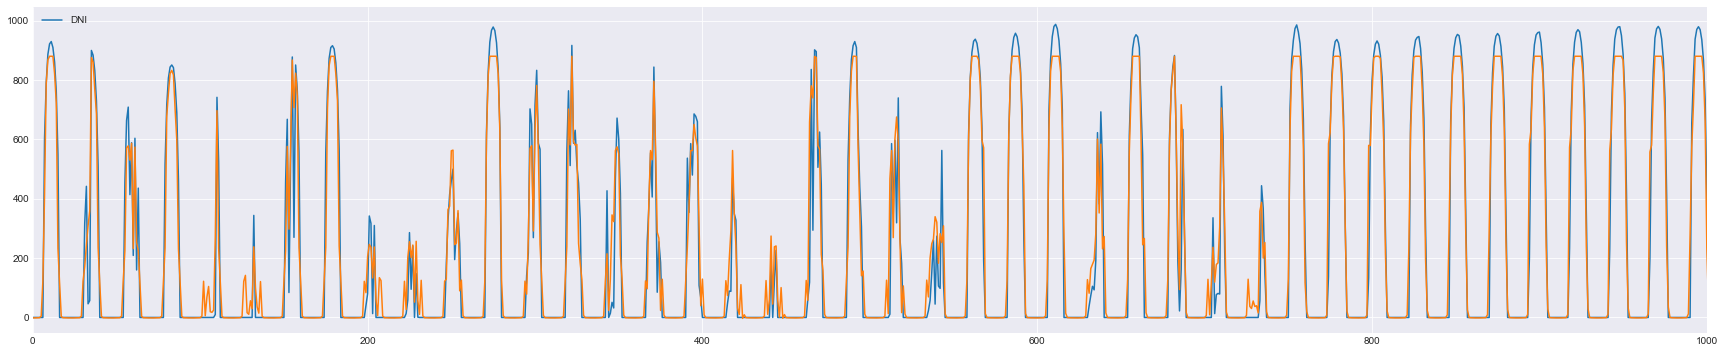

In [23]:
plt.figure(figsize = (30,6))

plot_x1 = np.arange(0,len(y))

plt.plot(plot_x1, y)

plt.plot(plot_x1[:len(y_train)]-1, trainPredict.ravel())

plt.xlim(0,1000)
plt.legend()
plt.show()

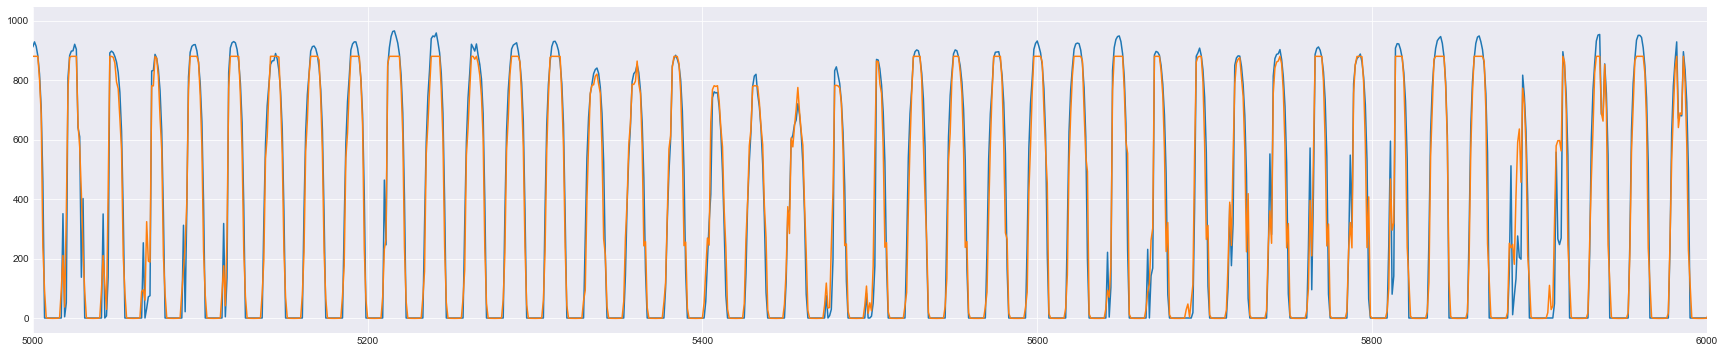

In [24]:
plt.figure(figsize = (30,6))

plot_x2 = np.arange(4161,4161 + len(y_test[:4161]))

plt.plot(plot_x2, y_test[:4161])

plt.plot(plot_x2-1, testPredict.ravel())

plt.xlim(5000, 6000)
plt.legend()
plt.show()